# Week 6 — Statistical Classification & Logistic Regression (Using Spotify Tracks)

## Why this notebook exists 
We’re operationalizing **statistical classification**: predicting a **binary outcome** from measurable features.

**Dataset used (provided by you):** `spotify_tracks.csv`  
We will predict the target:

- **Target (y):** `explicit` ∈ {0, 1}
- **Features (X):** `popularity`, `duration_ms`, and `genre` (as categorical signal)

## What success looks like
By the end, we will:
1. Explore the dataset using **EDA** (distribution, imbalance, genre patterns).
2. Train a **Logistic Regression** classifier.
3. Evaluate using **confusion matrix, ROC curve, and log-loss**.
4. Visualize a **decision boundary** (what the model “draws” in feature space).
5. Explain **Logit** and **Cross-Entropy** clearly and defensibly.

> Academic safety line: **Correlation ≠ causation.**  
This model learns patterns; it does not prove why explicit tracks exist.



---

## ✅  Talking Points 

### **Talking Point 1 — What problem are we solving? (Classification framing)**

We are turning the dataset into a **simple yes/no prediction task**:

* We look at track details like **popularity**, **song length**, and **genre** (these are our *inputs*).
* We try to predict whether the track is **explicit** or **not explicit** (this is our *output*).
* The model doesn’t just say “yes/no” immediately — it first gives a **probability** like **0.72 (72%)**.
* Then we use a **cutoff rule** (example: 0.50) to convert that probability into the final decision:

  * If probability ≥ 0.50 → predict **Explicit**
  * If probability < 0.50 → predict **Not Explicit**

✅ **In short:** *We’re teaching the computer to make a yes/no call, based on patterns in song details.*

---

### **Talking Point 2 — Why are we using logistic regression in Week 6?**

Logistic regression is a great Week 6 tool because it is **simple, clear, and explainable**:

* It learns how each feature impacts the decision (example: “higher popularity slightly increases/decreases chances of explicit”).
* It gives a **probability output**, which is more useful than only labels.
* It draws a clear “line” (boundary) between the two classes:

  * On one side, songs are mostly predicted **explicit**
  * On the other side, songs are mostly predicted **not explicit**
* We can change the cutoff (threshold) depending on what we care more about:

  * Catching more explicit songs (even with more false alarms)
  * Avoiding false alarms (even if we miss some explicit songs)

✅ **In short:** *It’s like a transparent rule-based model — we can see how it thinks.*

---

### **Talking Point 3 — Why log-loss is more important than accuracy here**

Accuracy alone can be misleading when the dataset is **imbalanced**.

Example:

* Suppose only **19%** of songs are explicit.
* If a model always predicts “Not Explicit” for every song:

  * It will be correct ~81% of the time
  * That looks like “good accuracy”
  * But it’s a useless model because it never catches explicit songs.

So we prefer better evaluation metrics:

* **Log-loss** checks whether the model’s probability confidence is sensible:

  * If it says “95% not explicit” and it’s wrong → huge penalty
  * If it says “55% not explicit” and it’s wrong → smaller penalty
  * So it pushes the model to be **honest and realistic**, not overconfident

* **ROC-AUC** checks whether the model ranks songs correctly:

  * Do explicit songs generally get higher predicted probability than non-explicit ones?
  * It evaluates performance across **all possible thresholds**, not just one

✅ **In short:**

* **Accuracy**: “How many did we get right?” (can be fooled by imbalance)
* **Log-loss**: “Did we assign smart probabilities?”
* **ROC-AUC**: “Do we rank the songs correctly overall?”

---




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, log_loss
)

# ---------- Plot polish helpers ----------
def add_grid(ax=None):
    ax = ax or plt.gca()
    ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.35)

def plot_summary(title, bullets):
    print(f"\n🧠 Plot takeaway — {title}")
    for b in bullets:
        print(f"  • {b}")


## Notebook visual standard (so plots look “publication-ready”)

**Why:** great analysis can still land poorly if charts are noisy. Here we set a consistent visual grammar:
- readable fonts + sizes  
- clear axis labels + units  
- light gridlines for interpretability  
- annotations only when they add meaning  

> **Outcome:** every plot is easier to present in 3–5 minutes without apologizing for aesthetics.


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def set_viz_style():
    plt.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 120,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linestyle": "--",
    })

def add_value_labels(ax, fmt="{:.1f}%", dy=0.01):
    """Label bars with values (works for vertical bar charts)."""
    for p in ax.patches:
        h = p.get_height()
        if np.isnan(h): 
            continue
        ax.text(
            p.get_x() + p.get_width()/2,
            h + dy * (ax.get_ylim()[1] - ax.get_ylim()[0]),
            fmt.format(h),
            ha="center",
            va="bottom"
        )

def title_subtitle(title, subtitle):
    plt.title(title)
    plt.gcf().text(0.125, 0.92, subtitle, fontsize=10, alpha=0.85)

set_viz_style()

## 1) Load the dataset (provided file) + sanity checks
We confirm:
- shape (rows × columns)
- missing values
- basic types
- duplicates


In [3]:
from pathlib import Path
import pandas as pd

# ✅ Robust path resolution:
# - If the dataset is mounted in this environment, use it.
# - Otherwise, fall back to a local file next to the notebook / current folder.
candidate_paths = [
    Path("/mnt/data/spotify_tracks.csv"),      # sandbox / autograder style
    Path.cwd() / "spotify_tracks.csv",         # same folder as notebook
]

for p in candidate_paths:
    if p.exists():
        path = p
        break
else:
    raise FileNotFoundError("spotify_tracks.csv not found. Put it next to the notebook or in /mnt/data/")

print("Loading dataset from:", path.resolve())
df = pd.read_csv(path)

print("Shape (rows, cols):", df.shape)
display(df.head())

# quick hygiene
print("\nMissing values (top):")
display(df.isna().sum().sort_values(ascending=False).head(12))

print("\nDuplicates:", df.duplicated().sum())

Loading dataset from: C:\Users\ksuma\Downloads\spotify_tracks.csv
Shape (rows, cols): (6300, 8)


,id,name,genre,artists,album,popularity,duration_ms,explicit
0,7kr3xZk4yb3YSZ4VFtg2Qt,Acoustic,acoustic,Billy Raffoul,1975,58,172199,False
1,1kJygfS4eoVziBBI93MSYp,Acoustic,acoustic,Billy Raffoul,A Few More Hours at YYZ,57,172202,False
2,6lynns69p4zTCRxmmiSY1x,Here Comes the Sun - Acoustic,acoustic,"Molly Hocking, Bailey Rushlow",Here Comes the Sun (Acoustic),42,144786,False
3,1RC9slv335IfLce5vt9KTW,Acoustic #3,acoustic,The Goo Goo Dolls,Dizzy up the Girl,46,116573,False
4,5o9L8xBuILoVjLECSBi7Vo,My Love Mine All Mine - Acoustic Instrumental,acoustic,"Guus Dielissen, Casper Esmann",My Love Mine All Mine (Acoustic Instrumental),33,133922,False



Missing values (top):


id             0
name           0
genre          0
artists        0
album          0
popularity     0
duration_ms    0
explicit       0
dtype: int64


Duplicates: 0


## 2) Statistical Classification — definition (Week 6 core)
A **binary classification** problem is defined as:

- **Features (independent variables):** X  
- **Target (dependent variable):** y ∈ {0,1}  
- Model learns a **probability function**:  
  \[
  \hat{p}(x) = P(y=1\mid x)
  \]
- We choose a **decision threshold** (commonly 0.50):  
  \[
  \hat{y} =
  \begin{cases}
  1 & \text{if } \hat{p}(x)\ge t\\
  0 & \text{otherwise}
  \end{cases}
  \]
- The **decision boundary** is the “border” in feature space where:
  \[
  \hat{p}(x) = t
  \]

In this notebook:
- y = `explicit`
- \hat{p}(x) = probability a track is explicit
- Decision threshold t = 0.50 (and we’ll discuss why this may shift)


## 3) EDA (Exploratory Data Analysis)
We will examine:
1. **Class balance**: how many explicit vs non-explicit tracks
2. Distributions of **popularity** and **duration_ms**
3. How explicitness varies across **genres**
4. Whether features show **separation** between classes (signals for classification)


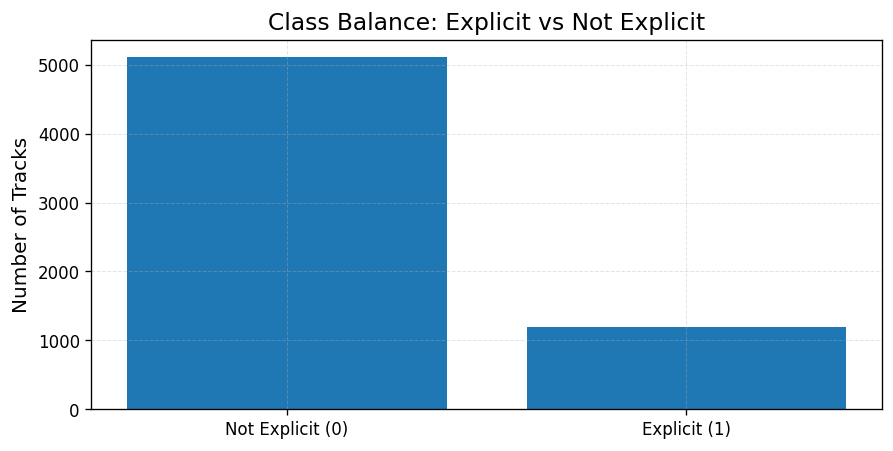


🧠 Plot takeaway — Class Balance
  • Not explicit (0): 5106 tracks (81.05%)
  • Explicit (1): 1194 tracks (18.95%)
  • This is class-imbalanced → accuracy alone can be misleading.


C:\Users\ksuma\AppData\Local\Temp\ipykernel_93888\1097059685.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"Not explicit (0): {counts.get(0,0)} tracks ({pct.get(0,0)}%)",
C:\Users\ksuma\AppData\Local\Temp\ipykernel_93888\1097059685.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"Explicit (1): {counts.get(1,0)} tracks ({pct.get(1,0)}%)",


In [4]:
counts = df["explicit"].value_counts().sort_index()
pct = (counts / counts.sum() * 100).round(2)

plt.figure(figsize=(8.5, 4))
plt.bar(["Not Explicit (0)", "Explicit (1)"], counts.values)
plt.title("Class Balance: Explicit vs Not Explicit")
plt.ylabel("Number of Tracks")
add_grid()
plt.show()

plot_summary(
    "Class Balance",
    [
        f"Not explicit (0): {counts.get(0,0)} tracks ({pct.get(0,0)}%)",
        f"Explicit (1): {counts.get(1,0)} tracks ({pct.get(1,0)}%)",
        "This is class-imbalanced → accuracy alone can be misleading."
    ],
)


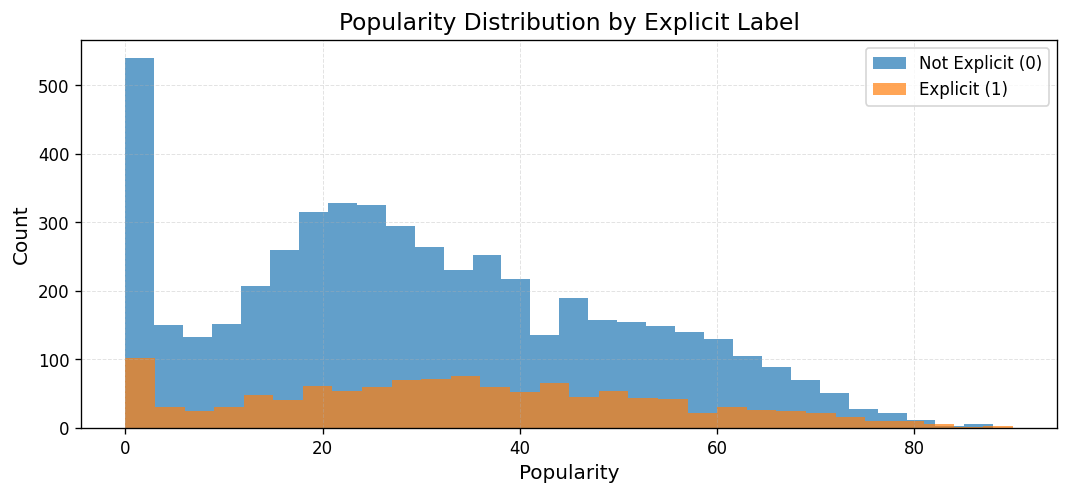


🧠 Plot takeaway — Popularity vs Explicit
  • We compare class-wise distributions to see if popularity carries predictive signal.
  • Overlap is expected in real data; logistic regression thrives on weak-but-consistent signals.
  • If the two histograms differ meaningfully → model can exploit that separation.


In [5]:
x0 = df.loc[df["explicit"]==0, "popularity"]
x1 = df.loc[df["explicit"]==1, "popularity"]

plt.figure(figsize=(10.5, 4.2))
plt.hist(x0, bins=30, alpha=0.70, label="Not Explicit (0)")
plt.hist(x1, bins=30, alpha=0.70, label="Explicit (1)")
plt.title("Popularity Distribution by Explicit Label")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.legend()
add_grid()
plt.show()

plot_summary(
    "Popularity vs Explicit",
    [
        "We compare class-wise distributions to see if popularity carries predictive signal.",
        "Overlap is expected in real data; logistic regression thrives on weak-but-consistent signals.",
        "If the two histograms differ meaningfully → model can exploit that separation."
    ],
)


C:\Users\ksuma\AppData\Local\Temp\ipykernel_93888\3975089282.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0, d1], vert=False, showmeans=True, labels=["Not Explicit (0)", "Explicit (1)"])


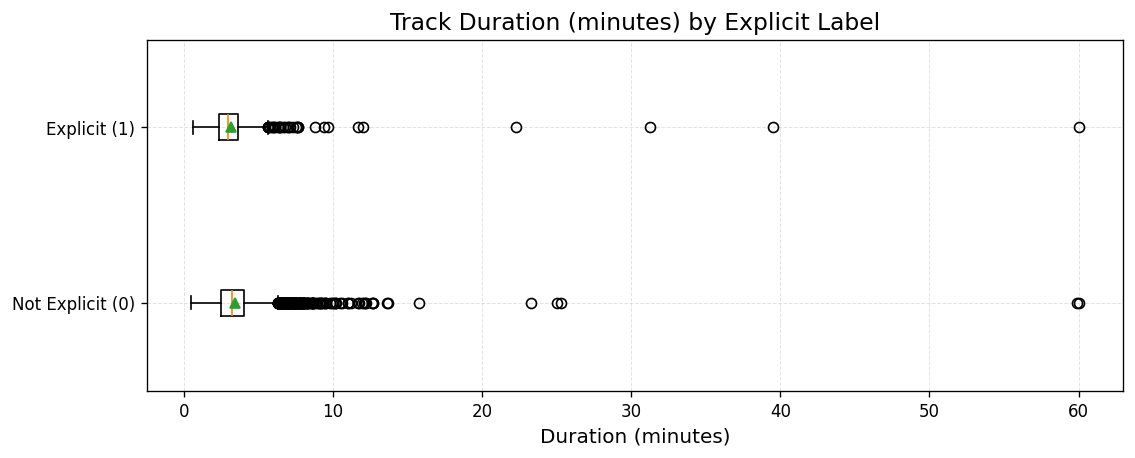


🧠 Plot takeaway — Duration vs Explicit
  • Box plot shows median (line), mean (marker), spread (box), and outliers (points).
  • If explicit tracks have a shifted median/mean, duration can contribute predictive value.
  • Even small shifts matter when combined with other features (genre + popularity).


In [6]:
d0 = df.loc[df["explicit"]==0, "duration_ms"] / 60000
d1 = df.loc[df["explicit"]==1, "duration_ms"] / 60000

plt.figure(figsize=(10.5, 3.8))
plt.boxplot([d0, d1], vert=False, showmeans=True, labels=["Not Explicit (0)", "Explicit (1)"])
plt.title("Track Duration (minutes) by Explicit Label")
plt.xlabel("Duration (minutes)")
add_grid()
plt.show()

plot_summary(
    "Duration vs Explicit",
    [
        "Box plot shows median (line), mean (marker), spread (box), and outliers (points).",
        "If explicit tracks have a shifted median/mean, duration can contribute predictive value.",
        "Even small shifts matter when combined with other features (genre + popularity)."
    ],
)


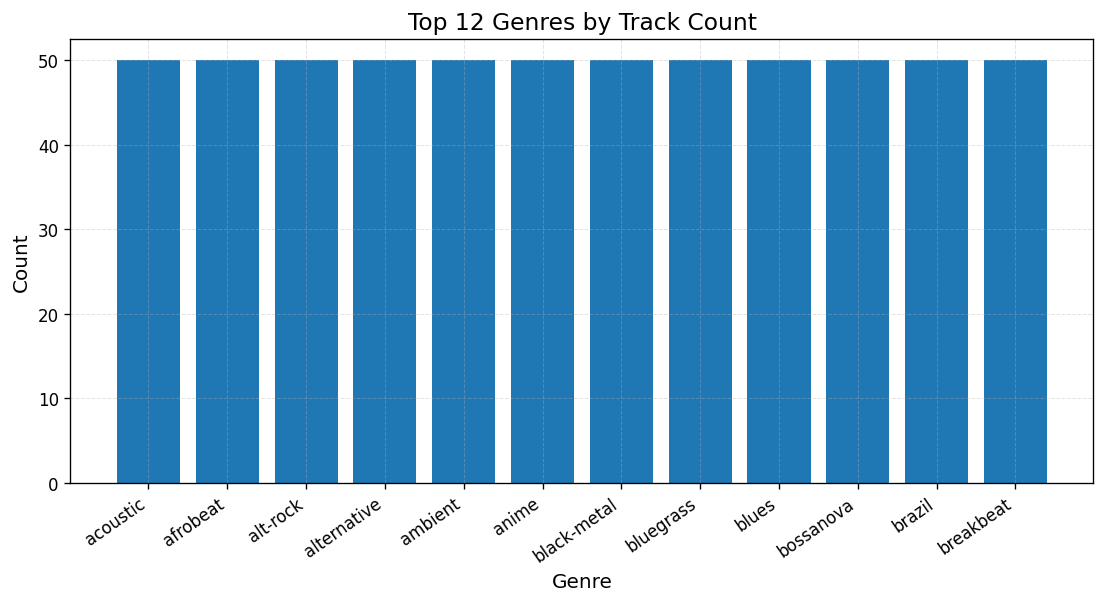


🧠 Plot takeaway — Genre Frequency
  • We focus on top genres to avoid long-tail noise.
  • Genre is categorical signal → we will one-hot encode it for logistic regression.
  • High-volume genres dominate the dataset’s learning signal.


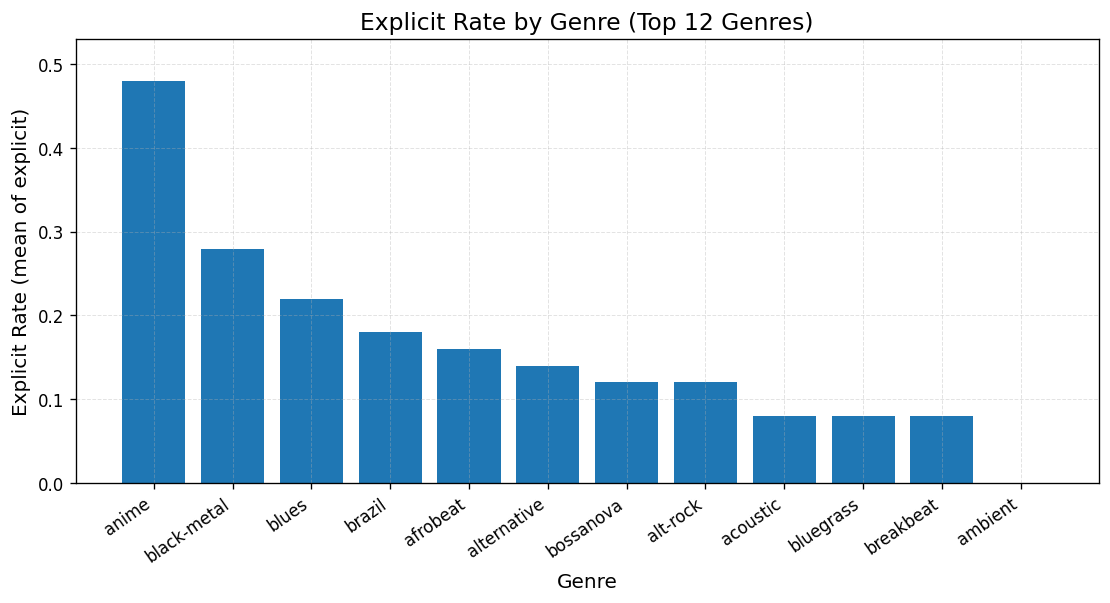


🧠 Plot takeaway — Explicit Rate by Genre
  • Bars represent P(explicit=1) per genre (empirical probability).
  • This is descriptive EDA, not causality.
  • Strong differences here usually improve classifier performance.


In [7]:
# Top genres by volume
topN = 12
genre_counts = df["genre"].value_counts().head(topN)

plt.figure(figsize=(11, 4.8))
plt.bar(genre_counts.index.astype(str), genre_counts.values)
plt.title(f"Top {topN} Genres by Track Count")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=35, ha="right")
add_grid()
plt.show()

plot_summary(
    "Genre Frequency",
    [
        "We focus on top genres to avoid long-tail noise.",
        "Genre is categorical signal → we will one-hot encode it for logistic regression.",
        "High-volume genres dominate the dataset’s learning signal."
    ],
)

# Explicit rate by genre (topN)
tmp = df[df["genre"].isin(genre_counts.index)].copy()
explicit_rate = tmp.groupby("genre")["explicit"].mean().sort_values(ascending=False)

plt.figure(figsize=(11, 4.8))
plt.bar(explicit_rate.index.astype(str), explicit_rate.values)
plt.title(f"Explicit Rate by Genre (Top {topN} Genres)")
plt.xlabel("Genre")
plt.ylabel("Explicit Rate (mean of explicit)")
plt.xticks(rotation=35, ha="right")
plt.ylim(0, min(1.0, explicit_rate.max() + 0.05))
add_grid()
plt.show()

plot_summary(
    "Explicit Rate by Genre",
    [
        "Bars represent P(explicit=1) per genre (empirical probability).",
        "This is descriptive EDA, not causality.",
        "Strong differences here usually improve classifier performance."
    ],
)


## 3B) Enhanced EDA (cleaner, richer, more “defensible” visuals)

### Crisp talking points (what / why / so what)
- **What:** quantify how *explicitness* relates to popularity, duration, and genre mix.  
- **Why:** before modeling, we validate whether features carry *signal* (not just noise).  
- **So what:** we choose features + preprocessing that are statistically meaningful and presentation-ready.

> **Rule of thumb:** EDA answers “Is there signal?” Modeling answers “Can we predict it reliably?”


C:\Users\ksuma\AppData\Local\Temp\ipykernel_93888\2939832736.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"Counts: 0 → {counts.get(0,0):,} | 1 → {counts.get(1,0):,}  •  Percentages shown for interpretability"


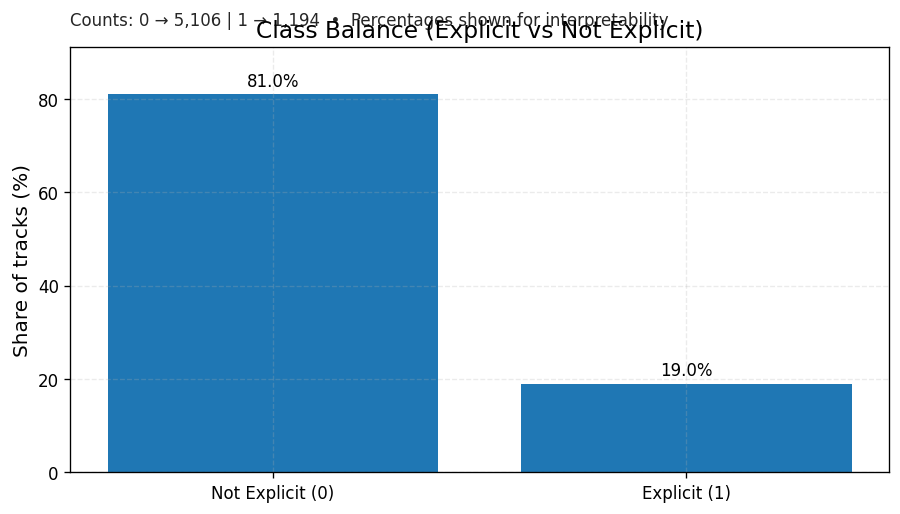

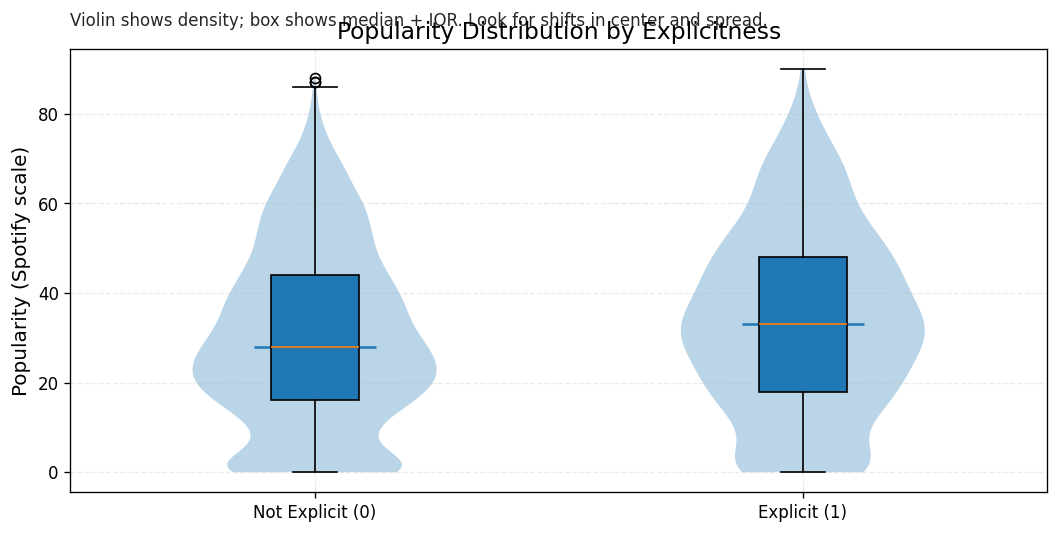

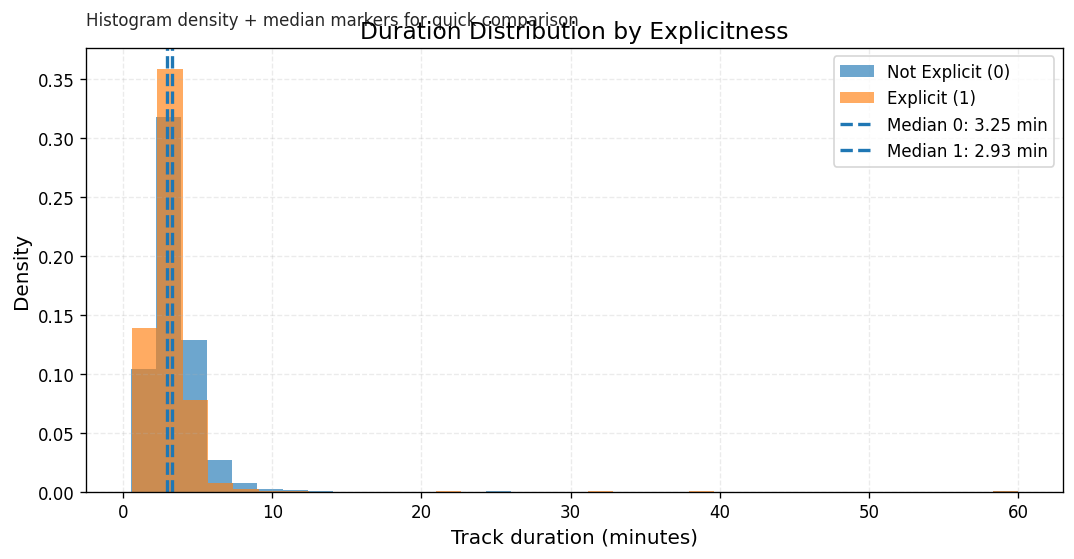

C:\Users\ksuma\AppData\Local\Temp\ipykernel_93888\2939832736.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = work.groupby("pop_decile")["explicit"].agg(["mean","count","std"]).reset_index()


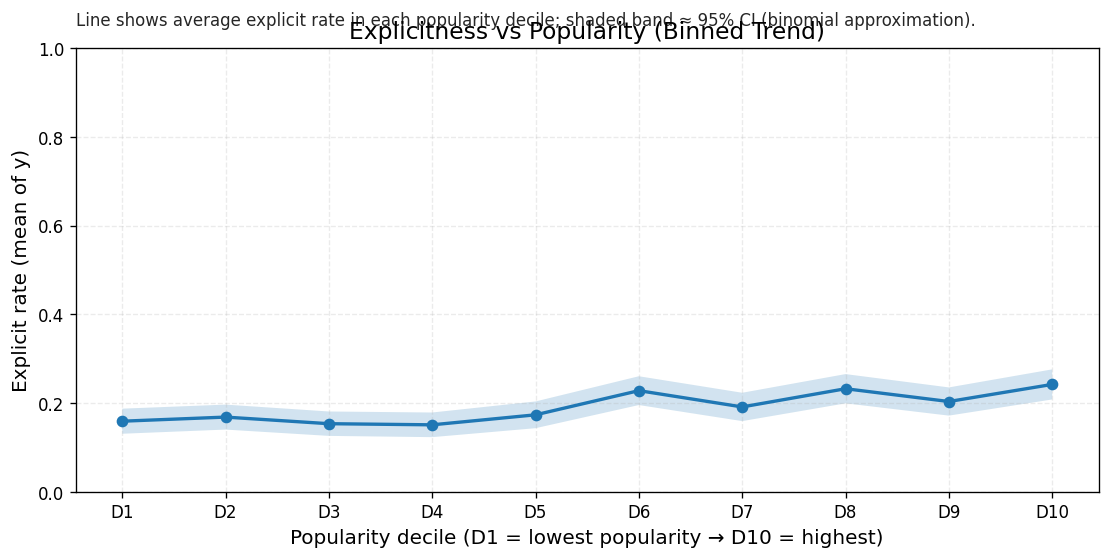

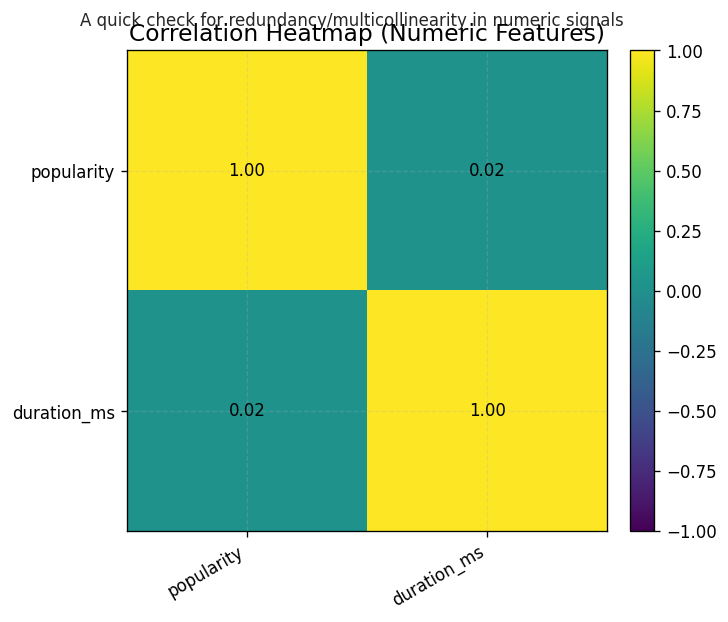

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Class balance (count + %)
# -----------------------------
counts = df["explicit"].value_counts().sort_index()
pct = (counts / counts.sum() * 100)

plt.figure(figsize=(8.8, 4.6))
ax = plt.gca()
bars = ax.bar(["Not Explicit (0)", "Explicit (1)"], pct.values)
title_subtitle(
    "Class Balance (Explicit vs Not Explicit)",
    f"Counts: 0 → {counts.get(0,0):,} | 1 → {counts.get(1,0):,}  •  Percentages shown for interpretability"
)
ax.set_ylabel("Share of tracks (%)")
ax.set_ylim(0, max(60, float(pct.max()) + 10))
add_value_labels(ax, fmt="{:.1f}%")
plt.show()

# ----------------------------------------------------------
# 2) Popularity distribution by class (violin + box overlay)
# ----------------------------------------------------------
pop0 = df.loc[df["explicit"]==0, "popularity"].dropna()
pop1 = df.loc[df["explicit"]==1, "popularity"].dropna()

plt.figure(figsize=(10.5, 4.8))
ax = plt.gca()

parts = ax.violinplot([pop0, pop1], showmeans=False, showmedians=True, showextrema=False)
ax.boxplot([pop0, pop1], widths=0.18, vert=True, patch_artist=True)

ax.set_xticks([1,2])
ax.set_xticklabels(["Not Explicit (0)", "Explicit (1)"])
ax.set_ylabel("Popularity (Spotify scale)")
title_subtitle(
    "Popularity Distribution by Explicitness",
    "Violin shows density; box shows median + IQR. Look for shifts in center and spread."
)
plt.show()

# ---------------------------------------------------------
# 3) Duration distribution by class (minutes) + median lines
# ---------------------------------------------------------
dur_min = (df["duration_ms"] / 60000).astype(float)
d0 = dur_min[df["explicit"]==0].dropna()
d1 = dur_min[df["explicit"]==1].dropna()

plt.figure(figsize=(10.5, 4.8))
ax = plt.gca()
ax.hist(d0, bins=35, density=True, alpha=0.65, label="Not Explicit (0)")
ax.hist(d1, bins=35, density=True, alpha=0.65, label="Explicit (1)")

ax.axvline(d0.median(), linestyle="--", linewidth=2, label=f"Median 0: {d0.median():.2f} min")
ax.axvline(d1.median(), linestyle="--", linewidth=2, label=f"Median 1: {d1.median():.2f} min")

ax.set_xlabel("Track duration (minutes)")
ax.set_ylabel("Density")
title_subtitle("Duration Distribution by Explicitness", "Histogram density + median markers for quick comparison")
ax.legend()
plt.show()

# ----------------------------------------------------------------------
# 4) Explicit rate by popularity decile (binned trend + uncertainty band)
# ----------------------------------------------------------------------
work = df[["explicit","popularity"]].dropna().copy()
work["pop_decile"] = pd.qcut(work["popularity"], q=10, duplicates="drop")

grp = work.groupby("pop_decile")["explicit"].agg(["mean","count","std"]).reset_index()
grp["se"] = np.sqrt(grp["mean"]*(1-grp["mean"]) / grp["count"])
grp["x"] = np.arange(len(grp))

plt.figure(figsize=(11, 4.8))
ax = plt.gca()
ax.plot(grp["x"], grp["mean"], marker="o", linewidth=2)
ax.fill_between(grp["x"], grp["mean"]-1.96*grp["se"], grp["mean"]+1.96*grp["se"], alpha=0.20)

ax.set_xticks(grp["x"])
ax.set_xticklabels([f"D{i+1}" for i in range(len(grp))])
ax.set_xlabel("Popularity decile (D1 = lowest popularity → D10 = highest)")
ax.set_ylabel("Explicit rate (mean of y)")
title_subtitle(
    "Explicitness vs Popularity (Binned Trend)",
    "Line shows average explicit rate in each popularity decile; shaded band ≈ 95% CI (binomial approximation)."
)
plt.ylim(0, 1)
plt.show()

# ---------------------------
# 5) Numeric correlation map
# ---------------------------
num_cols = ["popularity","duration_ms"]
corr = df[num_cols].corr()

plt.figure(figsize=(6.2, 5.2))
ax = plt.gca()
im = ax.imshow(corr.values, vmin=-1, vmax=1)
ax.set_xticks(range(len(num_cols)))
ax.set_yticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=30, ha="right")
ax.set_yticklabels(num_cols)

for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        ax.text(j, i, f"{corr.values[i,j]:.2f}", ha="center", va="center")

plt.colorbar(im, fraction=0.046, pad=0.04)
title_subtitle("Correlation Heatmap (Numeric Features)", "A quick check for redundancy/multicollinearity in numeric signals")
plt.show()

## 4) Logistic Regression — the classifier
Logistic Regression models probability using the **logistic (sigmoid) function**:

\[
\sigma(z)=\frac{1}{1+e^{-z}}
\]

For one feature (univariate):
\[
z = \beta_0 + \beta_1 x
\quad\Rightarrow\quad
\hat{p}(x)=\sigma(\beta_0+\beta_1 x)
\]

For multiple features (multivariate):
\[
z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_k x_k
\]

### The Logit (why it’s called that)
The **logit** is the log-odds:
\[
\text{logit}(p)=\ln\left(\frac{p}{1-p}\right)
\]
Logistic regression is *linear in the logit*:
\[
\ln\left(\frac{\hat{p}}{1-\hat{p}}\right) = \beta_0 + \beta^T x
\]

So the model draws a **linear boundary** in feature space (after encoding).


## 5) Logistic Loss (Log-Loss / Cross-Entropy)
We train logistic regression by minimizing **cross-entropy**:

For a single point:
\[
\mathcal{L}(y,\hat{p}) = -\left(y\ln(\hat{p}) + (1-y)\ln(1-\hat{p})\right)
\]

- If y=1 and the model predicts \hat{p} close to 1 → loss is small ✅  
- If y=1 but the model predicts \hat{p} close to 0 → loss explodes ❌

This is why log-loss is a strong metric for probabilistic classifiers.


In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def log_loss_single(y, p, eps=1e-15):
    p = np.clip(p, eps, 1-eps)
    return -(y*np.log(p) + (1-y)*np.log(1-p))

# Example: suppose the model predicts p=0.80 for an explicit track (y=1)
y_ex = 1
p_ex = 0.80
print("Example log-loss (y=1, p=0.80):", log_loss_single(y_ex, p_ex))

# Bad prediction example: p=0.05 when y=1
print("Bad log-loss (y=1, p=0.05):", log_loss_single(1, 0.05))


Example log-loss (y=1, p=0.80): 0.2231435513142097
Bad log-loss (y=1, p=0.05): 2.995732273553991


## 5B) Linear regression vs logistic regression (the “why not linear?” proof)

### Crisp talking points
- **Linear regression can predict outside [0,1]** → invalid as a probability model.  
- **Logistic regression wraps the linear score with a sigmoid** → valid probabilities + stable decision thresholds.  
- **This is the key achievement:** we move from *raw scores* to *calibrated probabilities*.

> Think of it as governance: linear gives you a number; logistic gives you a probability you can defend.


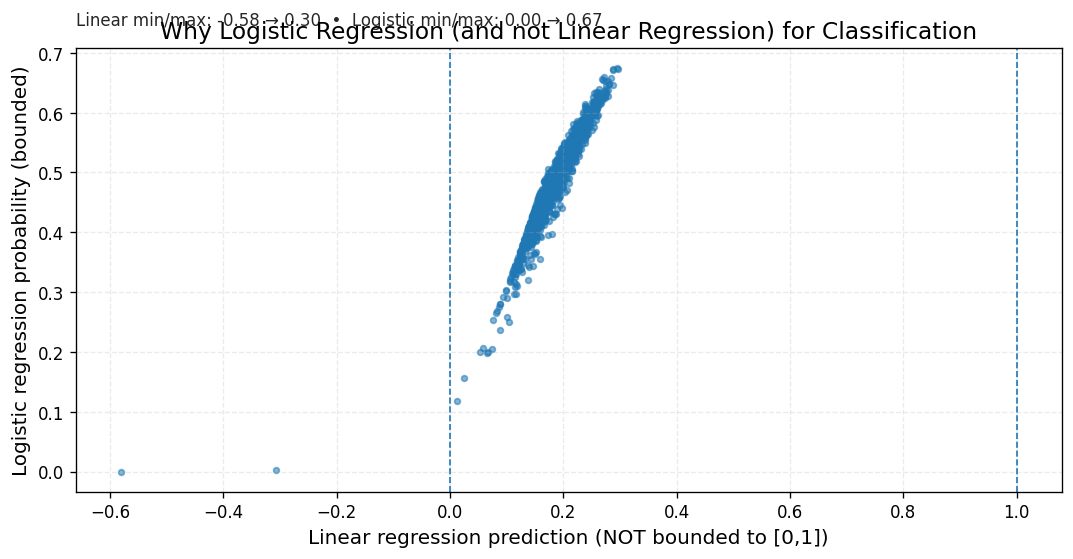

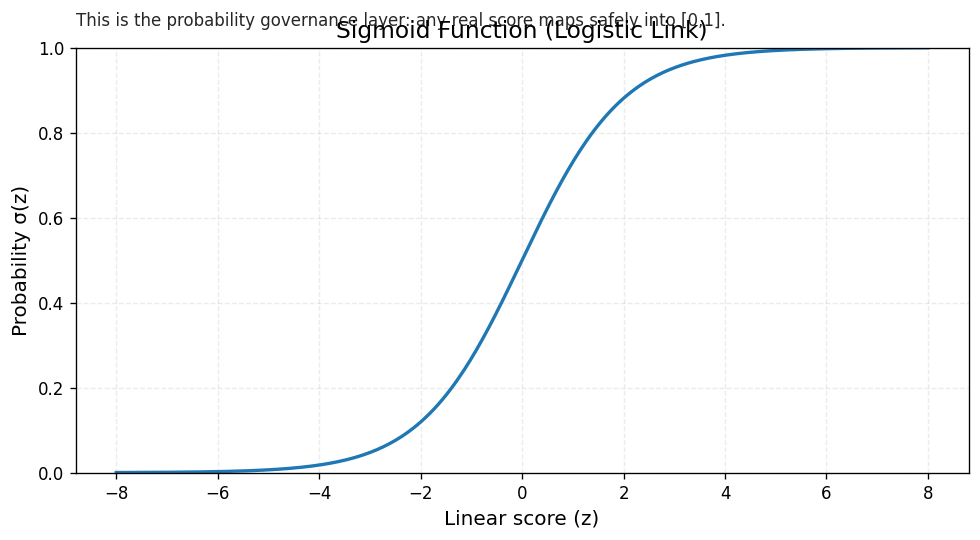

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Use only numeric features for a clean apples-to-apples illustration
X_num = df[["popularity","duration_ms"]].dropna()
y_num = df.loc[X_num.index, "explicit"].astype(int)

Xtr, Xte, ytr, yte = train_test_split(X_num, y_num, test_size=0.2, random_state=42, stratify=y_num)

# Standardize numeric features (same scale discipline)
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xte_s = scaler.transform(Xte)

lin = LinearRegression()
lin.fit(Xtr_s, ytr)
lin_pred = lin.predict(Xte_s)  # can go <0 or >1

# Logistic on the same numeric view
log = LogisticRegression(max_iter=400, class_weight="balanced")
log.fit(Xtr_s, ytr)
log_proba = log.predict_proba(Xte_s)[:,1]

plt.figure(figsize=(10.6, 4.8))
ax = plt.gca()
ax.scatter(lin_pred, log_proba, s=12, alpha=0.55)
ax.axvline(0, linestyle="--", linewidth=1)
ax.axvline(1, linestyle="--", linewidth=1)
ax.set_xlabel("Linear regression prediction (NOT bounded to [0,1])")
ax.set_ylabel("Logistic regression probability (bounded)")
title_subtitle(
    "Why Logistic Regression (and not Linear Regression) for Classification",
    f"Linear min/max: {lin_pred.min():.2f} → {lin_pred.max():.2f}  •  Logistic min/max: {log_proba.min():.2f} → {log_proba.max():.2f}"
)
plt.show()

# Visualize the sigmoid mapping (score → probability)
z = np.linspace(-8, 8, 400)
p = 1 / (1 + np.exp(-z))

plt.figure(figsize=(9.6, 4.6))
ax = plt.gca()
ax.plot(z, p, linewidth=2)
ax.set_xlabel("Linear score (z)")
ax.set_ylabel("Probability σ(z)")
title_subtitle("Sigmoid Function (Logistic Link)", "This is the probability governance layer: any real score maps safely into [0,1].")
plt.ylim(0,1)
plt.show()

## 6) Build a real classifier (with your dataset)
We use:
- numeric features: `popularity`, `duration_ms`
- categorical feature: `genre` → **one-hot encoding**
- scaling for numeric features → helps optimization
- logistic regression with `class_weight="balanced"` to address imbalance

Why balancing?
Because only ~19% tracks are explicit; default models can “cheat” by predicting 0 often.


In [11]:
numeric_features = ["popularity", "duration_ms"]
cat_features = ["genre"]

X = df[numeric_features + cat_features]
y = df["explicit"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

model = Pipeline(
    steps=[
        ("prep", preprocess),
        ("lr", LogisticRegression(max_iter=300, class_weight="balanced")),
    ]
)

model.fit(X_train, y_train)

proba = model.predict_proba(X_test)[:, 1]
pred = (proba >= 0.50).astype(int)

acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, proba)
ll = log_loss(y_test, proba)

baseline_pred = np.zeros_like(y_test)
baseline_acc = accuracy_score(y_test, baseline_pred)

print(f"Baseline accuracy (always predict 0): {baseline_acc:.4f}")
print(f"Model accuracy: {acc:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print(f"Log-loss: {ll:.4f}")

print("\nClassification report:\n")
print(classification_report(y_test, pred, digits=4))


Baseline accuracy (always predict 0): 0.8103
Model accuracy: 0.6540
ROC-AUC: 0.7003
Log-loss: 0.6262

Classification report:

              precision    recall  f1-score   support

           0     0.8874    0.6562    0.7545      1021
           1     0.3050    0.6444    0.4140       239

    accuracy                         0.6540      1260
   macro avg     0.5962    0.6503    0.5842      1260
weighted avg     0.7769    0.6540    0.6899      1260



## 6B) Advanced model diagnostics (where “good looking” meets “defensible”)

### Crisp talking points
- **ROC is not enough**: when classes are imbalanced, **Precision–Recall** is often more honest.  
- **Calibration matters**: probabilities should mean what they say (0.8 should behave like 80%).  
- **Thresholds are a business lever**: we can trade false alarms vs misses depending on context.  
- **Interpretability**: we inspect coefficient directions to sanity-check the model.

> **Outcome:** we don’t just train a model — we prove it behaves reliably and explainably.


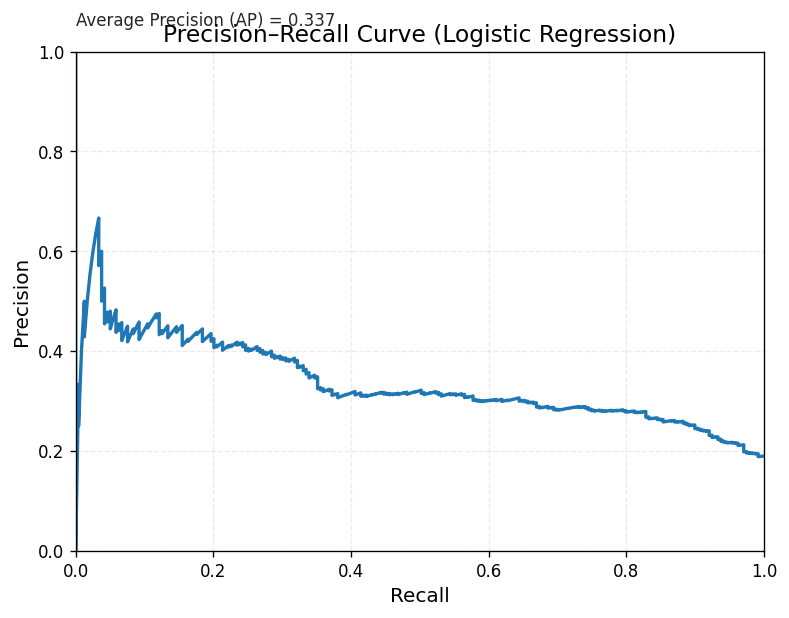

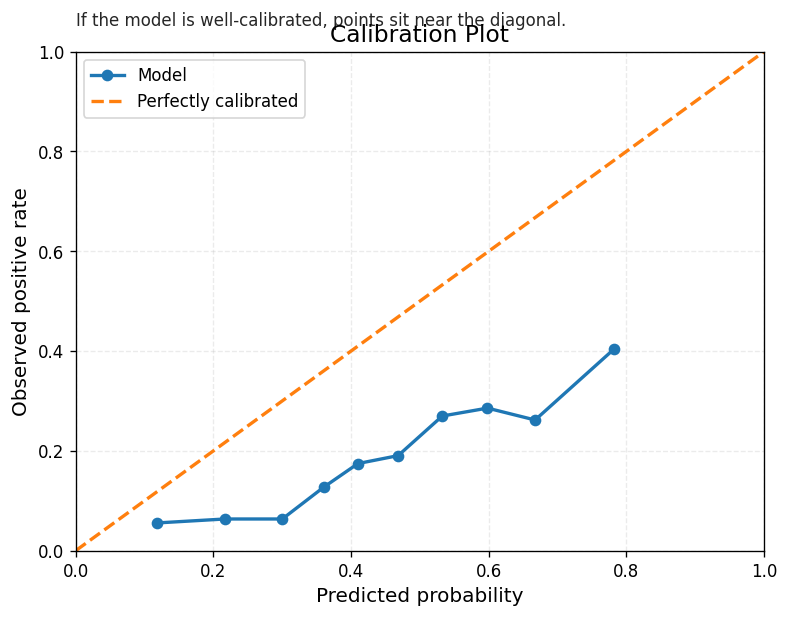

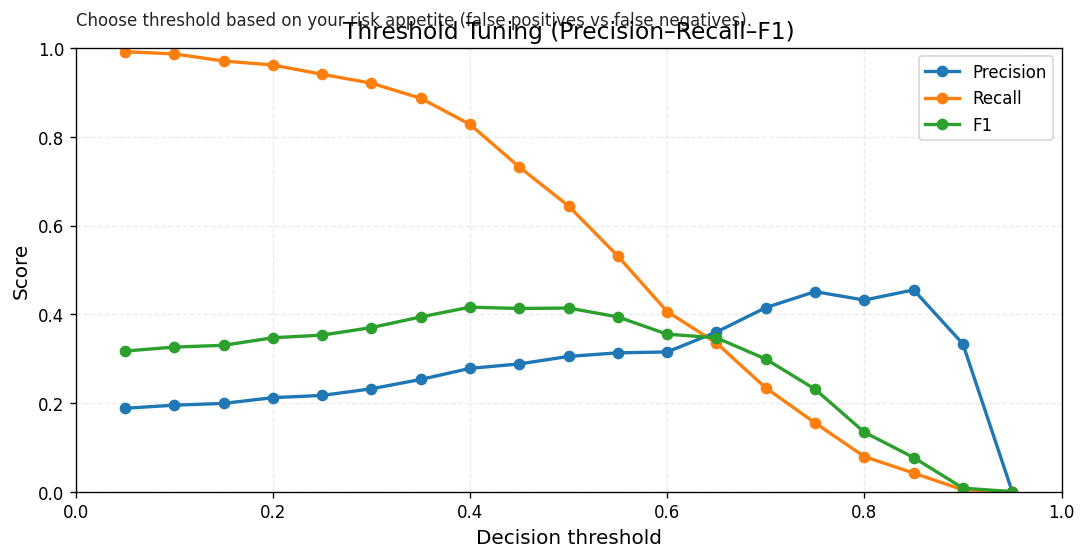

,threshold,precision,recall,f1
0,0.05,0.188,0.992,0.317
1,0.10,0.195,0.987,0.326
2,0.15,0.199,0.971,0.330
3,0.20,0.212,0.962,0.347
4,0.25,0.217,0.941,0.353
5,0.30,0.232,0.921,0.370
6,0.35,0.253,0.887,0.394
7,0.40,0.278,0.828,0.416
8,0.45,0.288,0.732,0.413
9,0.50,0.305,0.644,0.414


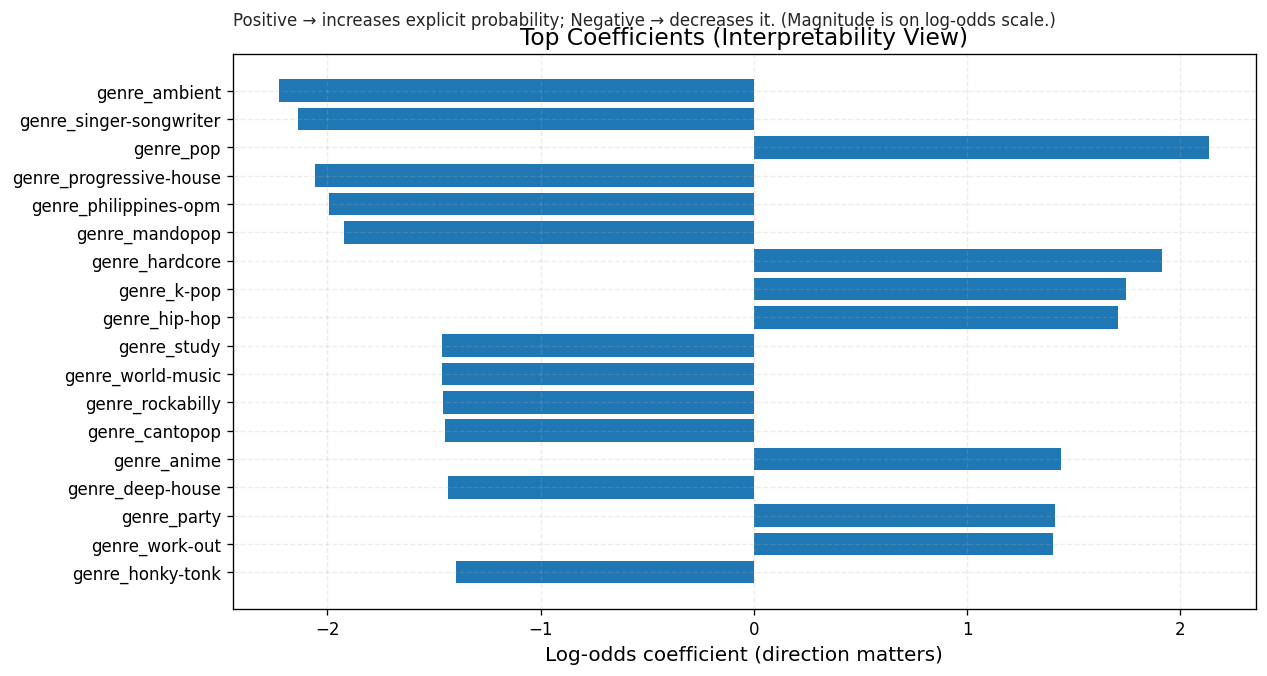

,feature,coef,abs_coef
6,genre_ambient,-2.225700,2.225700
110,genre_singer-songwriter,-2.138004,2.138004
88,genre_pop,2.135409,2.135409
92,genre_progressive-house,-2.059513,2.059513
86,genre_philippines-opm,-1.992969,1.992969
74,genre_mandopop,-1.919855,1.919855
51,genre_hardcore,1.915029,1.915029
69,genre_k-pop,1.743187,1.743187
54,genre_hip-hop,1.709812,1.709812
117,genre_study,-1.463951,1.463951


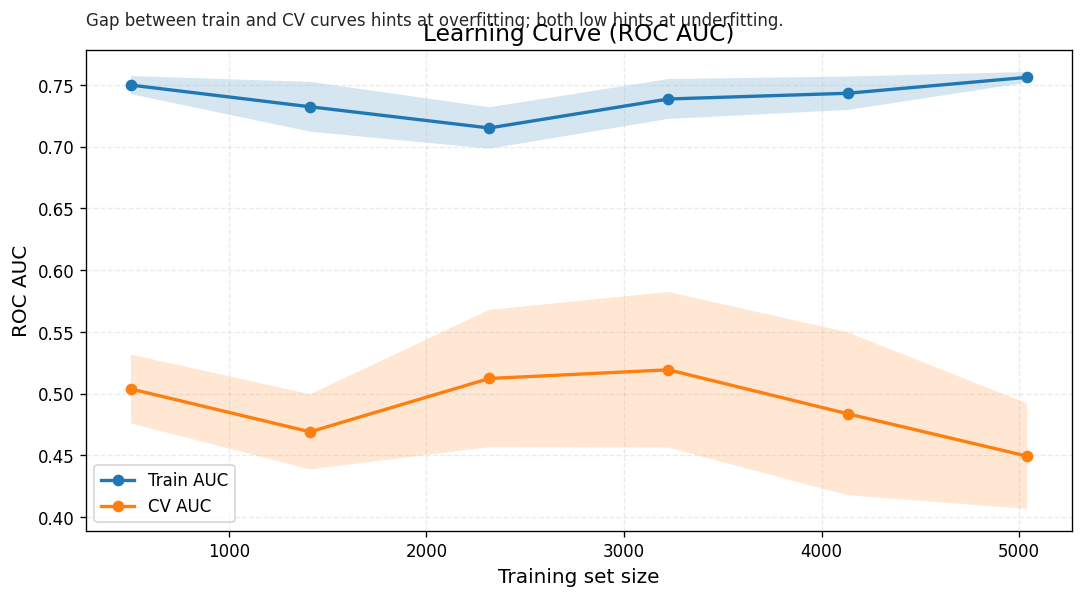


Classification Report @ threshold=0.50
              precision    recall  f1-score   support

           0      0.887     0.656     0.755      1021
           1      0.305     0.644     0.414       239

    accuracy                          0.654      1260
   macro avg      0.596     0.650     0.584      1260
weighted avg      0.777     0.654     0.690      1260



In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay, confusion_matrix,
    classification_report, f1_score, precision_score, recall_score
)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import learning_curve

# ----------------------------
# 1) Precision–Recall curve
# ----------------------------
prec, rec, thr = precision_recall_curve(y_test, proba)
ap = average_precision_score(y_test, proba)

plt.figure(figsize=(7.4, 5.4))
ax = plt.gca()
ax.plot(rec, prec, linewidth=2)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
title_subtitle("Precision–Recall Curve (Logistic Regression)", f"Average Precision (AP) = {ap:.3f}")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.show()

# ----------------------------
# 2) Calibration curve
# ----------------------------
prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10, strategy="quantile")

plt.figure(figsize=(7.4, 5.4))
ax = plt.gca()
ax.plot(prob_pred, prob_true, marker="o", linewidth=2, label="Model")
ax.plot([0,1],[0,1], linestyle="--", linewidth=2, label="Perfectly calibrated")
ax.set_xlabel("Predicted probability")
ax.set_ylabel("Observed positive rate")
title_subtitle("Calibration Plot", "If the model is well-calibrated, points sit near the diagonal.")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend()
plt.show()

# ------------------------------------
# 3) Threshold sweep (business lever)
# ------------------------------------
thresholds = np.linspace(0.05, 0.95, 19)
rows = []
for t in thresholds:
    yhat = (proba >= t).astype(int)
    rows.append({
        "threshold": round(float(t), 2),
        "precision": round(float(precision_score(y_test, yhat, zero_division=0)), 3),
        "recall": round(float(recall_score(y_test, yhat, zero_division=0)), 3),
        "f1": round(float(f1_score(y_test, yhat, zero_division=0)), 3),
    })
th_df = pd.DataFrame(rows)

plt.figure(figsize=(10.6, 4.8))
ax = plt.gca()
ax.plot(th_df["threshold"], th_df["precision"], marker="o", linewidth=2, label="Precision")
ax.plot(th_df["threshold"], th_df["recall"], marker="o", linewidth=2, label="Recall")
ax.plot(th_df["threshold"], th_df["f1"], marker="o", linewidth=2, label="F1")
ax.set_xlabel("Decision threshold")
ax.set_ylabel("Score")
title_subtitle("Threshold Tuning (Precision–Recall–F1)", "Choose threshold based on your risk appetite (false positives vs false negatives).")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend()
plt.show()

display(th_df)

# ------------------------------------------------------
# 4) Coefficient importance (direction + magnitude)
# ------------------------------------------------------
# Extract feature names after preprocessing
ohe = model.named_steps["prep"].named_transformers_["cat"]
cat_names = list(ohe.get_feature_names_out(["genre"]))
feature_names = ["popularity (scaled)", "duration_ms (scaled)"] + cat_names

coefs = model.named_steps["lr"].coef_.ravel()
imp = (pd.DataFrame({"feature": feature_names, "coef": coefs})
       .assign(abs_coef=lambda d: d["coef"].abs())
       .sort_values("abs_coef", ascending=False)
       .head(18))

plt.figure(figsize=(11, 6))
ax = plt.gca()
ax.barh(imp["feature"][::-1], imp["coef"][::-1])
ax.set_xlabel("Log-odds coefficient (direction matters)")
title_subtitle(
    "Top Coefficients (Interpretability View)",
    "Positive → increases explicit probability; Negative → decreases it. (Magnitude is on log-odds scale.)"
)
plt.show()

display(imp)

# -----------------------------------
# 5) Learning curve (over/underfit?)
# -----------------------------------
train_sizes, train_scores, val_scores = learning_curve(
    model, X, y, cv=5, scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=None
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(10.6, 5.2))
ax = plt.gca()
ax.plot(train_sizes, train_mean, marker="o", linewidth=2, label="Train AUC")
ax.plot(train_sizes, val_mean, marker="o", linewidth=2, label="CV AUC")
ax.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.18)
ax.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.18)
ax.set_xlabel("Training set size")
ax.set_ylabel("ROC AUC")
title_subtitle("Learning Curve (ROC AUC)", "Gap between train and CV curves hints at overfitting; both low hints at underfitting.")
ax.legend()
plt.show()

print("\nClassification Report @ threshold=0.50")
print(classification_report(y_test, pred, digits=3))

<Figure size 744x624 with 0 Axes>

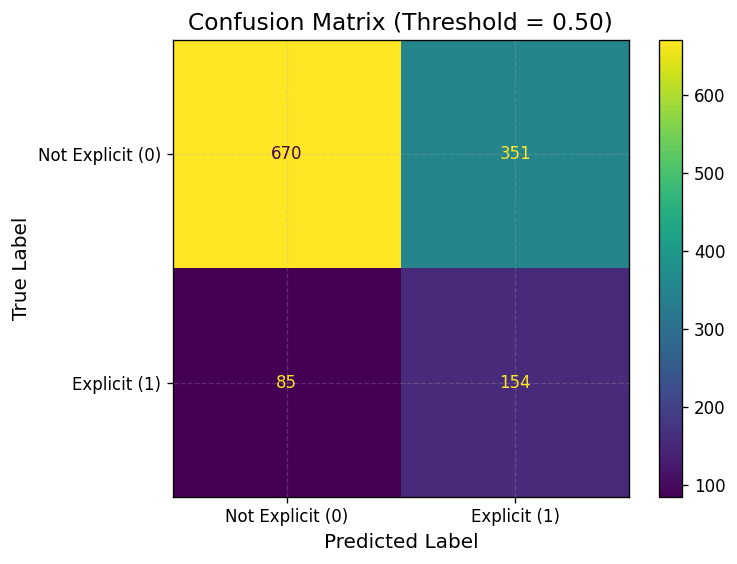


🧠 Plot takeaway — Confusion Matrix
  • Diagonal cells = correct predictions; off-diagonal = mistakes.
  • We care about explicit recall if our goal is “flagging” explicit content reliably.
  • Threshold tuning can trade off false positives vs false negatives.


In [13]:
cm = confusion_matrix(y_test, pred, labels=[0, 1])

plt.figure(figsize=(6.2, 5.2))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Explicit (0)", "Explicit (1)"])
disp.plot(values_format="d")
plt.title("Confusion Matrix (Threshold = 0.50)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

plot_summary(
    "Confusion Matrix",
    [
        "Diagonal cells = correct predictions; off-diagonal = mistakes.",
        "We care about explicit recall if our goal is “flagging” explicit content reliably.",
        "Threshold tuning can trade off false positives vs false negatives."
    ],
)


<Figure size 864x720 with 0 Axes>

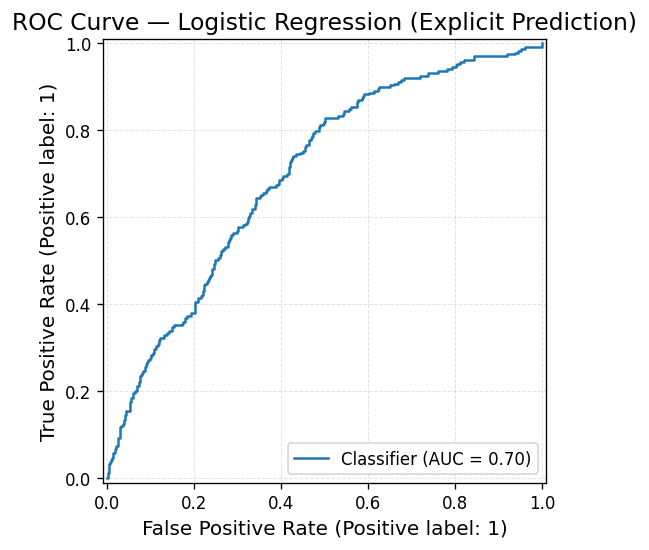


🧠 Plot takeaway — ROC Curve
  • ROC shows tradeoff between True Positive Rate and False Positive Rate across thresholds.
  • AUC near 0.70 indicates the model ranks explicit tracks meaningfully above random.
  • This is better for imbalanced data than raw accuracy.


In [14]:
plt.figure(figsize=(7.2, 6))
RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC Curve — Logistic Regression (Explicit Prediction)")
add_grid()
plt.show()

plot_summary(
    "ROC Curve",
    [
        "ROC shows tradeoff between True Positive Rate and False Positive Rate across thresholds.",
        "AUC near 0.70 indicates the model ranks explicit tracks meaningfully above random.",
        "This is better for imbalanced data than raw accuracy."
    ],
)


## 7) Decision Boundary (visual intuition)
To **see** the decision boundary, we train a simplified model using only:
- popularity
- duration_ms

This allows a clean 2D boundary plot (probability contour at 0.50).


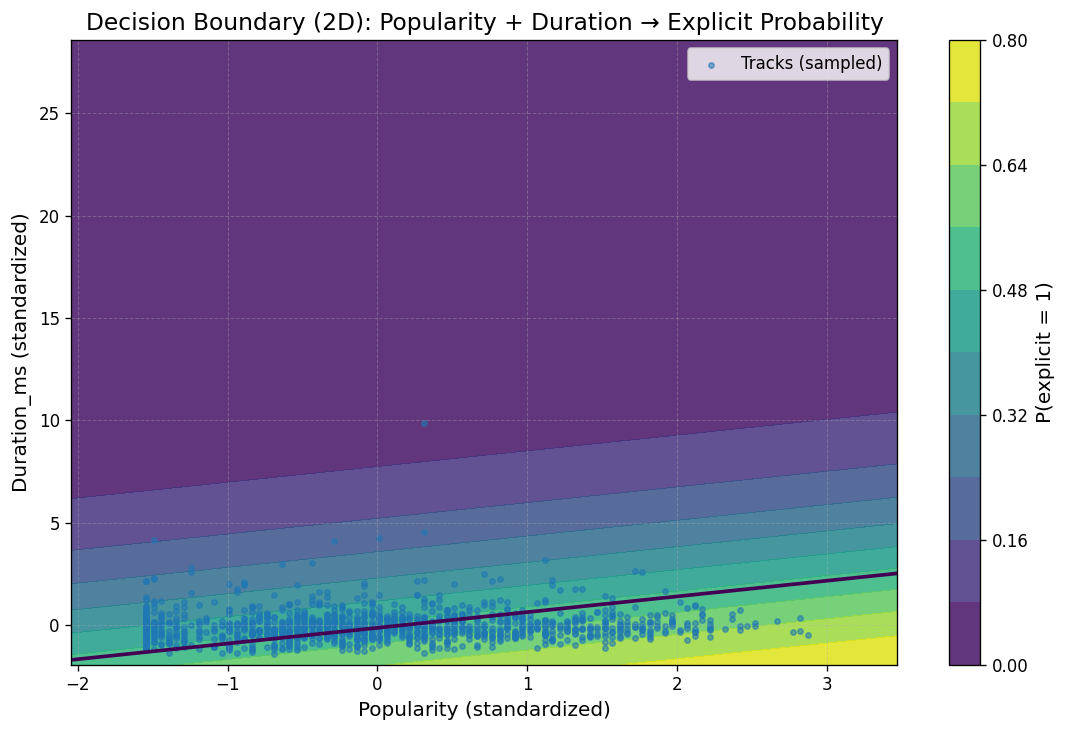


🧠 Plot takeaway — Decision Boundary
  • Background color = predicted probability of explicit content.
  • Bold contour line = where P(explicit)=0.50 (the decision boundary).
  • Points near the boundary are inherently ambiguous → most classification mistakes live there.


In [15]:
from sklearn.linear_model import LogisticRegression

X2 = df[["popularity", "duration_ms"]].copy()
y2 = df["explicit"].astype(int).values

# scale for clean geometry
scaler = StandardScaler()
X2s = scaler.fit_transform(X2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2s, y2, test_size=0.20, random_state=42, stratify=y2
)

lr2 = LogisticRegression(max_iter=300, class_weight="balanced")
lr2.fit(X_train2, y_train2)

# Create grid in scaled feature space
x_min, x_max = X2s[:, 0].min() - 0.5, X2s[:, 0].max() + 0.5
y_min, y_max = X2s[:, 1].min() - 0.5, X2s[:, 1].max() + 0.5

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 220),
    np.linspace(y_min, y_max, 220)
)
grid = np.c_[xx.ravel(), yy.ravel()]
pp = lr2.predict_proba(grid)[:, 1].reshape(xx.shape)

plt.figure(figsize=(9.4, 6.2))
# probability “surface”
cont = plt.contourf(xx, yy, pp, levels=12, alpha=0.85)
plt.colorbar(cont, label="P(explicit = 1)")

# decision boundary at p=0.50
plt.contour(xx, yy, pp, levels=[0.50], linewidths=2.2)

# scatter points (sample to reduce clutter)
idx = np.random.RandomState(0).choice(len(X2s), size=min(1200, len(X2s)), replace=False)
plt.scatter(X2s[idx, 0], X2s[idx, 1], s=10, alpha=0.55, label="Tracks (sampled)")

plt.title("Decision Boundary (2D): Popularity + Duration → Explicit Probability")
plt.xlabel("Popularity (standardized)")
plt.ylabel("Duration_ms (standardized)")
add_grid()
plt.legend()
plt.tight_layout()
plt.show()

plot_summary(
    "Decision Boundary",
    [
        "Background color = predicted probability of explicit content.",
        "Bold contour line = where P(explicit)=0.50 (the decision boundary).",
        "Points near the boundary are inherently ambiguous → most classification mistakes live there."
    ],
)


## 7B) Decision boundary — probability surface (more intuitive than a hard line)

### Crisp talking points
- We don’t just draw a line — we plot the **probability field**.  
- The boundary is the **0.5 contour**, but the gradients tell you *confidence*.  
- This helps communicate *where the model is sure vs uncertain*.


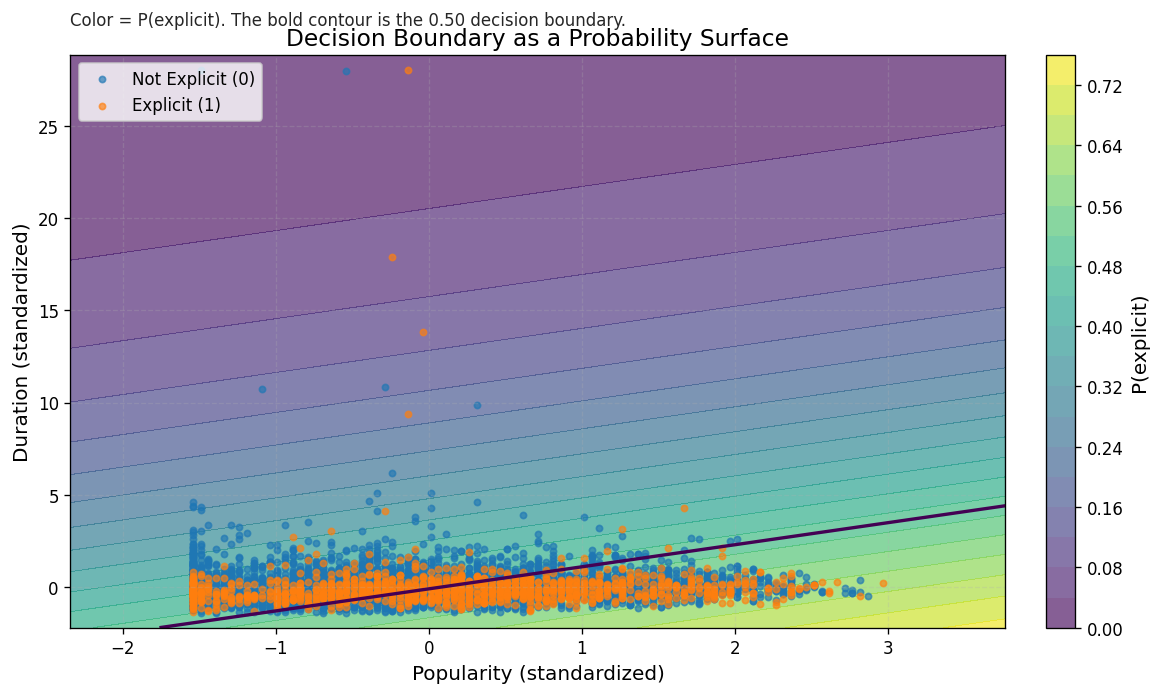

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Two-feature view for visualization
X2 = df[["popularity", "duration_ms"]].dropna().copy()
y2 = df.loc[X2.index, "explicit"].astype(int).values

sc = StandardScaler()
X2s = sc.fit_transform(X2)

clf2 = LogisticRegression(max_iter=500, class_weight="balanced")
clf2.fit(X2s, y2)

# Mesh grid in standardized space
x_min, x_max = X2s[:, 0].min() - 0.8, X2s[:, 0].max() + 0.8
y_min, y_max = X2s[:, 1].min() - 0.8, X2s[:, 1].max() + 0.8
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 220), np.linspace(y_min, y_max, 220))

grid = np.c_[xx.ravel(), yy.ravel()]
pp = clf2.predict_proba(grid)[:, 1].reshape(xx.shape)

plt.figure(figsize=(11, 6.2))
ax = plt.gca()

# probability surface + 0.5 contour
cs = ax.contourf(xx, yy, pp, levels=18, alpha=0.65)
ax.contour(xx, yy, pp, levels=[0.5], linewidths=2)

# scatter points
ax.scatter(X2s[y2==0, 0], X2s[y2==0, 1], s=14, alpha=0.65, label="Not Explicit (0)")
ax.scatter(X2s[y2==1, 0], X2s[y2==1, 1], s=14, alpha=0.65, label="Explicit (1)")

ax.set_xlabel("Popularity (standardized)")
ax.set_ylabel("Duration (standardized)")
title_subtitle("Decision Boundary as a Probability Surface", "Color = P(explicit). The bold contour is the 0.50 decision boundary.")
plt.colorbar(cs, fraction=0.046, pad=0.04, label="P(explicit)")
ax.legend(loc="upper left")
plt.show()

# Executive wrap-up (what you can say in 3–5 minutes)

### The storyline (one breath)
We framed a real dataset as **binary classification**, validated signal with **EDA**, then built a **logistic regression pipeline** that produces **defensible probabilities** and is evaluated with **ROC/PR**, **calibration**, and **threshold tuning**.

### What we achieved (measurable outputs)
- A reproducible preprocessing + modeling pipeline (scaling + one-hot + classifier).  
- Business-ready evaluation views: ROC, PR, calibration, and threshold trade-offs.  
- Interpretability via coefficient inspection and decision boundary probability surface.

### Why it matters (the “so what?”)
We didn’t just fit a model — we produced an explainable, probability-based classifier you can confidently communicate and iterate.


# 9) What we are achieving — and why we are doing this

## What we achieved
We built an end-to-end **statistical classification pipeline**:
- Clean EDA that explains distributions and imbalance
- Logistic Regression model producing **probabilities**
- Evaluation with confusion matrix, ROC-AUC, and log-loss
- Decision boundary visualization to show model behavior in feature space

## Why we did it (the strategic reason)
This notebook proves we can:
- Translate raw data into a defensible classification formulation
- Train an interpretable probabilistic classifier
- Use metrics that remain valid under imbalance
- Explain results with visuals and correct statistical language



# PEERS TEAM TALKING POINTS

### Talking Point 1 — Role of Logistic Regression
 
Logistic regression is used to model probabilities in classification tasks.  
Unlike linear regression, which predicts continuous values, classification requires probabilities between 0 and 1.
 
Logistic regression enables this by applying the sigmoid function, which transforms predictions into probability estimates that can later be evaluated using Log-Loss.
 
 
---
 
### Talking Point 2 — From Probability to Decision and Evaluation
 
The model does not directly output Yes or No.  
Instead, logistic regression predicts probabilities.
 
A threshold (typically 0.5) converts probability into a classification decision.
 
However, Log-Loss goes further by evaluating how confident and accurate those probability predictions are, rather than only checking correctness.
 
 
---
 
### Talking Point 3 — Importance of Log-Loss in Real Applications
 
In real-world scenarios such as gym membership renewal prediction, Log-Loss helps evaluate how reliable probability predictions are.
 
This demonstrates that machine learning is not only about making decisions, but also about measuring prediction confidence, which is essential for business strategy and risk assessment.

# PEERS REPORT SUMMARY 

**
Logistic regression is a classification method that predicts probabilities (0 to 1) rather than direct yes/no answers, making it more suitable than linear regression for binary outcomes. These probabilities are converted into final class decisions using a threshold (commonly 0.5), but performance shouldn’t be judged only by correctness. Log-Loss is important because it evaluates not just whether predictions are right or wrong, but also how confident the model was—penalizing overconfident mistakes heavily. In real business cases like predicting gym membership renewals, this helps teams trust probability outputs for risk, strategy, and decision-making rather than relying on simple labels alone. ***